<a href="https://colab.research.google.com/github/S-abk/GA_TSP/blob/main/GA_Travelling_Salesman_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import operator
import pandas as pd

class City:
    """
    Represents a city with x and y coordinates.
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        """
        Calculate Euclidean distance to another city.
        """
        x_dis = abs(self.x - city.x)
        y_dis = abs(self.y - city.y)
        distance = np.sqrt((x_dis ** 2) + (y_dis ** 2))
        return distance

    def __repr__(self):
        return f"({self.x},{self.y})"


class Fitness:
    """
    Represents the fitness of a route (list of cities).
    """
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def route_distance(self):
        """
        Calculate the total distance of the route.
        """
        if self.distance == 0:
            path_distance = 0
            for i in range(len(self.route)):
                from_city = self.route[i]
                to_city = self.route[i + 1] if i + 1 < len(self.route) else self.route[0]
                path_distance += from_city.distance(to_city)
            self.distance = path_distance
        return self.distance

    def route_fitness(self):
        """
        Calculate the fitness of the route. Fitness is the inverse of distance.
        """
        if self.fitness == 0:
            self.fitness = 1 / float(self.route_distance())
        return self.fitness

# Test City and Fitness classes
city1 = City(0, 0)
city2 = City(3, 4)
print(f"Distance between {city1} and {city2}: {city1.distance(city2)}")

route = [city1, city2]
fitness = Fitness(route)
print(f"Fitness of the route {route}: {fitness.route_fitness()}")


Distance between (0,0) and (3,4): 5.0
Fitness of the route [(0,0), (3,4)]: 0.1


Welcome to the Traveling Salesman Problem Solver using Genetic Algorithm!

Number of Cities: The total number of cities among which the shortest route is to be found.
Enter the number of cities: 10

Population Size: The number of possible routes that the genetic algorithm will start with.
Enter the population size: 50

Elite Size: The number of top routes that are passed directly to the next generation.
Enter the elite size: 10

Mutation Rate: The probability (between 0 and 1) that a route will undergo mutation.
Enter the mutation rate: .1

Generations: The number of generations for which the algorithm will run.
Enter the number of generations: 100
Initial Distance: 722.2820640247706
Final Distance: 538.0266823924621


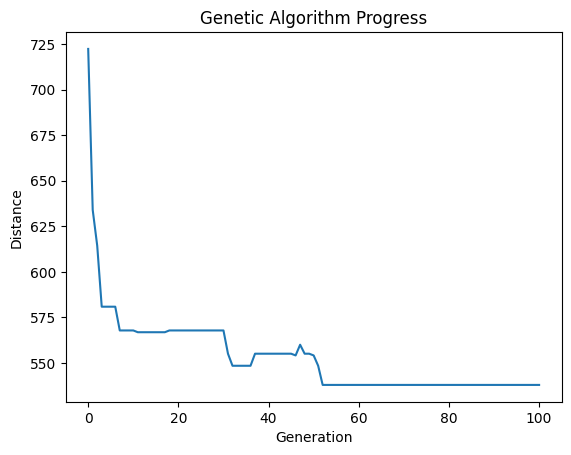

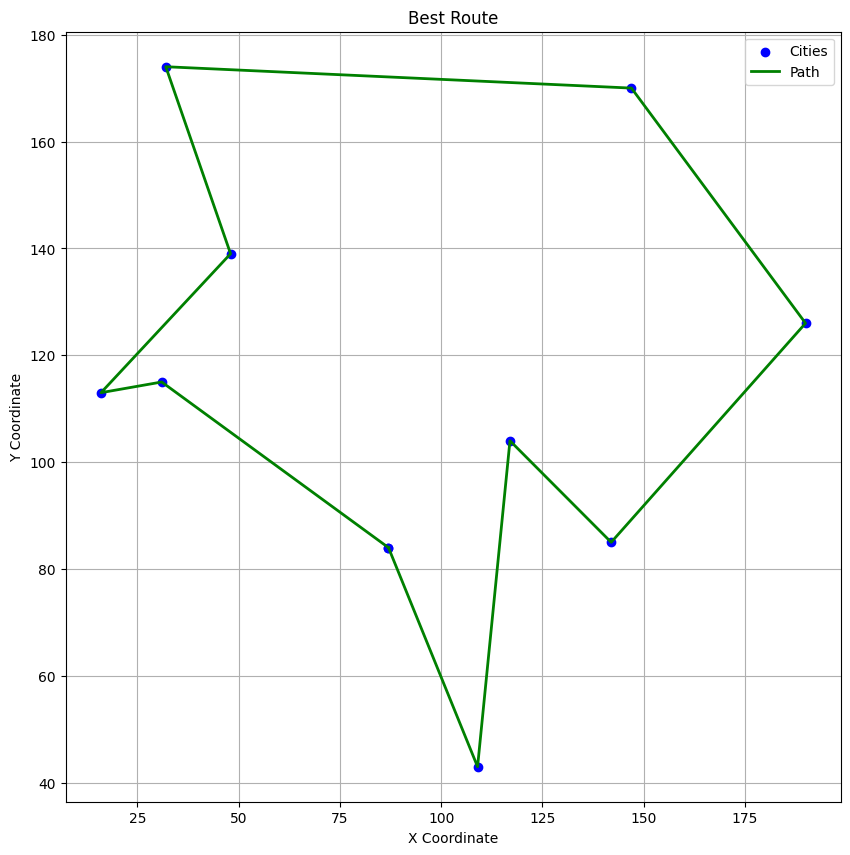

In [ ]:
# Merge the new methods with the existing methods to form a complete GeneticAlgorithmTSP class

class GeneticAlgorithmTSP:
    """
    Genetic Algorithm for solving the Traveling Salesman Problem (TSP).
    """
    def __init__(self, city_list, pop_size=100, elite_size=20, mutation_rate=0.01, generations=500):
        """
        Initialize parameters for the genetic algorithm.
        """
        self.city_list = city_list
        self.pop_size = pop_size
        self.elite_size = elite_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.population = self.initial_population()
        self.progress = []

    def create_route(self):
        """
        Generate a random route (permutation of cities).
        """
        return random.sample(self.city_list, len(self.city_list))

    def initial_population(self):
        """
        Create the initial population of routes.
        """
        population = [self.create_route() for _ in range(self.pop_size)]
        return population

    def rank_routes(self):
        """
        Rank the routes in the population based on their fitness.
        """
        fitness_results = {i: Fitness(self.population[i]).route_fitness() for i in range(len(self.population))}
        return sorted(fitness_results.items(), key=operator.itemgetter(1), reverse=True)

    def select_parents(self):
        """
        Select parent routes for crossover using elitism and fitness proportionate selection.
        """
        ranked_routes = self.rank_routes()
        selection_results = []

        # Elitism: Directly select the top routes
        for i in range(self.elite_size):
            selection_results.append(ranked_routes[i][0])

        # Fitness Proportionate Selection
        df = pd.DataFrame(np.array(ranked_routes), columns=["Index", "Fitness"])
        df['cum_sum'] = df.Fitness.cumsum()
        df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()

        for i in range(len(ranked_routes) - self.elite_size):
            pick = 100 * random.random()
            for i in range(len(ranked_routes)):
                if pick <= df.iat[i, 2]:
                    selection_results.append(ranked_routes[i][0])
                    break
        return selection_results

    def crossover(self, parent1, parent2):
        """
        Perform crossover between two parent routes to create a child route.
        """
        child = []
        child_p1 = []
        child_p2 = []

        # Randomly select a subset of the first parent
        gene_a = int(random.random() * len(parent1))
        gene_b = int(random.random() * len(parent1))
        start_gene = min(gene_a, gene_b)
        end_gene = max(gene_a, gene_b)

        # Get the genes from parent1 between start_gene and end_gene
        child_p1 = parent1[start_gene:end_gene]

        # Get the remaining genes from parent2 not in child_p1
        child_p2 = [item for item in parent2 if item not in child_p1]

        # Combine genes from both parents to form the child
        child = child_p1 + child_p2
        return child

    def mutate(self, route):
        """
        Perform mutation on a route.
        """
        for swapped in range(len(route)):
            if random.random() < self.mutation_rate:
                swap_with = int(random.random() * len(route))

                city1 = route[swapped]
                city2 = route[swap_with]

                route[swapped] = city2
                route[swap_with] = city1
        return route

    def next_generation(self):
        """
        Generate the next population.
        """
        ranked_routes = self.rank_routes()
        selection_results = self.select_parents()
        mating_pool = [self.population[i] for i in selection_results]

        # Elitism: Directly carry the best routes to the next generation
        children = mating_pool[:self.elite_size]

        # Generate the remaining children through crossover
        while len(children) < self.pop_size:
            parent1 = random.choice(mating_pool)
            parent2 = random.choice(mating_pool)
            child = self.crossover(parent1, parent2)
            children.append(child)

        # Apply mutation to the entire population
        self.population = [self.mutate(child) for child in children]

    def run(self):
        """
        Execute the genetic algorithm and track the progress.
        """
        self.progress.append(1 / self.rank_routes()[0][1])
        print(f"Initial Distance: {self.progress[0]}")

        for i in range(self.generations):
            self.next_generation()
            self.progress.append(1 / self.rank_routes()[0][1])

        print(f"Final Distance: {self.progress[-1]}")

    def plot_progress(self):
        """
        Plot the progress of the algorithm across generations.
        """
        plt.plot(self.progress)
        plt.title("Genetic Algorithm Progress")
        plt.xlabel("Generation")
        plt.ylabel("Distance")
        plt.show()

    def plot_best_route(self):
        """
        Plot the best route found by the algorithm.
        """
        # Get the best route
        best_route_idx = self.rank_routes()[0][0]
        best_route = self.population[best_route_idx]

        # Extract the x and y coordinates of the cities in the best route
        x_coords = [city.x for city in best_route]
        y_coords = [city.y for city in best_route]

        # Close the loop by connecting the last city to the first
        x_coords.append(best_route[0].x)
        y_coords.append(best_route[0].y)

        # Create the plot
        plt.figure(figsize=(10, 10))
        plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Cities')
        plt.plot(x_coords, y_coords, c='green', linestyle='-', linewidth=2, label='Path')
        plt.title("Best Route")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.grid(True)
        plt.show()


# Function to get user input for the genetic algorithm parameters
def get_user_input():
    try:
        print("Welcome to the Traveling Salesman Problem Solver using Genetic Algorithm!")

        # Number of Cities
        print("\nNumber of Cities: The total number of cities among which the shortest route is to be found.")
        num_cities = int(input("Enter the number of cities: "))

        # Population Size
        print("\nPopulation Size: The number of possible routes that the genetic algorithm will start with.")
        pop_size = int(input("Enter the population size: "))

        # Elite Size
        print("\nElite Size: The number of top routes that are passed directly to the next generation.")
        elite_size = int(input("Enter the elite size: "))

        # Mutation Rate
        print("\nMutation Rate: The probability (between 0 and 1) that a route will undergo mutation.")
        mutation_rate = float(input("Enter the mutation rate: "))

        # Number of Generations
        print("\nGenerations: The number of generations for which the algorithm will run.")
        generations = int(input("Enter the number of generations: "))

        return {
            'num_cities': num_cities,
            'pop_size': pop_size,
            'elite_size': elite_size,
            'mutation_rate': mutation_rate,
            'generations': generations
        }
    except ValueError:
        print("Invalid input. Please enter the correct data types.")
        return None

# Function to run the genetic algorithm based on user input
def run_genetic_algorithm(user_input):
    # Generate random cities
    cities = [City(x=int(random.random() * 200), y=int(random.random() * 200)) for _ in range(user_input['num_cities'])]

    # Initialize and run the genetic algorithm
    gen_algo = GeneticAlgorithmTSP(
        cities,
        pop_size=user_input['pop_size'],
        elite_size=user_input['elite_size'],
        mutation_rate=user_input['mutation_rate'],
        generations=user_input['generations']
    )
    gen_algo.run()

    # Plot the progress
    gen_algo.plot_progress()

    # Plot the best route
    gen_algo.plot_best_route()

# Get user input and run the algorithm
user_input = get_user_input()
if user_input:
    run_genetic_algorithm(user_input)
